In [30]:
import requests

EMAIL = "xi183728@ucf.edu.edu"
journals = ["Personnel Psychology", "Entrepreneurship Theory and Practice", "Journal of Management"]
journal_issn = {}

for journal in journals:
    url = f"https://api.crossref.org/journals?query={journal}&mailto={EMAIL}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        items = data.get("message", {}).get("items", [])
        
        # 尝试在返回结果中找到标题完全匹配的期刊
        matched_item = None
        for item in items:
            if item.get("title", "").lower() == journal.lower():
                matched_item = item
                break
        
        if matched_item:
            journal_issn[journal] = matched_item.get("ISSN", "No ISSN found")
        else:
            journal_issn[journal] = "No ISSN found"
    else:
        print(f"Failed to fetch ISSN for {journal}, status code: {response.status_code}")

# 输出结果
for journal, issn in journal_issn.items():
    print(f"Journal: {journal}, ISSN: {issn}")


Journal: Personnel Psychology, ISSN: ['0031-5826', '1744-6570']
Journal: Entrepreneurship Theory and Practice, ISSN: ['1042-2587', '1540-8520', '1540-6520']
Journal: Journal of Management, ISSN: ['0149-2063', '1557-1211']


In [10]:
journal_info = {}

for journal, issns in journal_issn.items():
    if isinstance(issns, list):
        journal_info[journal] = []
        for issn in issns:
            url = f"https://api.crossref.org/journals/{issn}?mailto={EMAIL}"
            response = requests.get(url)
            
            if response.status_code == 200:
                data = response.json().get("message", {})
                journal_info[journal].append(data)
            else:
                print(f"Failed to fetch data for {journal} (ISSN: {issn}), status code: {response.status_code}")
    else:
        print(f"No valid ISSN found for {journal}")

# information
for journal, entries in journal_info.items():
    print(f"\nJournal: {journal}")
    for entry in entries:
        print(f"Information:")
        for key, value in entry.items():
            print(f"{key}: {value}")
        print("-" * 80)



Journal: Personnel Psychology
Information:
last-status-check-time: 1739592840688
counts: {'current-dois': 116, 'backfile-dois': 3890, 'total-dois': 4006}
breakdowns: {'dois-by-issued-year': [[2005, 116], [2006, 99], [2007, 89], [2004, 82], [2023, 75], [2022, 75], [2016, 75], [2013, 69], [2008, 67], [1959, 67], [2020, 66], [2011, 66], [2010, 66], [2012, 65], [2009, 65], [2019, 63], [1978, 60], [2021, 59], [2018, 59], [2015, 58], [1972, 57], [2014, 55], [1980, 55], [1973, 53], [1970, 53], [1998, 52], [1982, 51], [1971, 51], [1995, 50], [1954, 50], [1950, 50], [1977, 49], [1976, 49], [1962, 49], [1958, 49], [1955, 49], [2017, 48], [1983, 48], [1981, 48], [1979, 48], [1969, 48], [1997, 47], [1974, 47], [2000, 46], [1994, 46], [1961, 46], [1968, 45], [1951, 45], [2003, 44], [1999, 44], [1996, 44], [1960, 44], [1952, 44], [1948, 44], [1993, 43], [1965, 43], [1963, 43], [1957, 43], [2002, 42], [2001, 42], [1987, 42], [1984, 42], [1966, 42], [1956, 42], [1953, 42], [1986, 41], [1964, 41], [19

In [30]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time

# Journal ISSN configurations
journals = {
    "Personnel Psychology": "1744-6570",
    "Entrepreneurship Theory and Practice": "1540-6520"
}

def fetch_journal_abstracts(journal_name, issn, start_date="2020-01-01"):
    """Fetch all abstracts for a journal since start_date"""
    results = []
    offset = 0
    rows = 100
    
    while True:
        url = (
            f"https://api.crossref.org/journals/{issn}/works?"
            f"filter=from-pub-date:{start_date}&rows={rows}&offset={offset}"
        )
        
        try:
            response = requests.get(url)
            data = response.json()
            items = data["message"]["items"]
            
            if not items:
                break
                
            for item in items:
                if "abstract" in item:
                    # Get basic metadata
                    title = item.get("title", [""])[0]
                    doi = item.get("DOI", "")
                    
                    # Get and clean abstract
                    abstract = BeautifulSoup(item["abstract"], "html.parser").get_text()
                    
                    # Get publication date
                    pub_date = None
                    if "published-print" in item:
                        pub_date = item["published-print"]["date-parts"][0]
                    elif "published-online" in item:
                        pub_date = item["published-online"]["date-parts"][0]
                    
                    if pub_date:
                        pub_date = "-".join(map(str, pub_date))
                    
                    results.append({
                        "Journal": journal_name,
                        "Title": title,
                        "Abstract": abstract,
                        "DOI": doi,
                        "Published_Date": pub_date
                    })
            
            print(f"Fetched {len(results)} abstracts from {journal_name}")
            offset += rows
            time.sleep(1)  # Rate limiting
            
        except Exception as e:
            print(f"Error fetching {journal_name} at offset {offset}: {e}")
            break
    
    return results

# Fetch abstracts for all journals
all_results = []
for journal, issn in journals.items():
    journal_results = fetch_journal_abstracts(journal, issn)
    all_results.extend(journal_results)

# Create DataFrame
df = pd.DataFrame(all_results)

# Save to Excel
df.to_excel("journal_abstracts.xlsx", index=False)

print("\nSummary:")
print(f"Total abstracts collected: {len(df)}")
for journal in journals:
    count = len(df[df['Journal'] == journal])
    print(f"{journal}: {count} abstracts")

Fetched 48 abstracts from Personnel Psychology
Fetched 90 abstracts from Personnel Psychology
Fetched 136 abstracts from Personnel Psychology
Fetched 147 abstracts from Personnel Psychology
Fetched 99 abstracts from Entrepreneurship Theory and Practice
Fetched 196 abstracts from Entrepreneurship Theory and Practice
Fetched 273 abstracts from Entrepreneurship Theory and Practice

Summary:
Total abstracts collected: 420
Personnel Psychology: 147 abstracts
Entrepreneurship Theory and Practice: 273 abstracts


In [35]:
import pandas as pd
import openai
import time
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# Set your OpenAI API key
openai.api_key = 'I deleted it after completing the task'

def clean_abstract_with_gpt(abstract):
    """Remove copyright statements using GPT"""
    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Remove any copyright statements, publisher information, or rights reserved text from the following abstract. Keep only the actual research abstract content."},
                {"role": "user", "content": abstract}
            ],
            temperature=0
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error cleaning abstract: {e}")
        return abstract

def process_batch(abstracts):
    """Process a batch of abstracts using ThreadPoolExecutor"""
    with ThreadPoolExecutor(max_workers=10) as executor:
        results = list(tqdm(
            executor.map(clean_abstract_with_gpt, abstracts),
            total=len(abstracts),
            desc="Cleaning abstracts"
        ))
    return results

# Read the original Excel file
df = pd.read_excel("journal_abstracts.xlsx")

# Create a copy of the original abstract column
df['Original_Abstract'] = df['Abstract']

# Clean abstracts using parallel processing
cleaned_abstracts = process_batch(df['Abstract'].tolist())

# Add cleaned abstracts to dataframe
df['Cleaned_Abstract'] = cleaned_abstracts

# Reorder columns to put abstracts side by side
df = df[['Journal', 'Title', 'Original_Abstract', 'Cleaned_Abstract', 'DOI', 'Published_Date']]

# Save to new Excel file
df.to_excel("journal_abstracts_cleaned.xlsx", index=False)

print("\nDone! Results saved to journal_abstracts_cleaned.xlsx")

Cleaning abstracts: 100%|██████████| 420/420 [01:08<00:00,  6.15it/s]


Done! Results saved to journal_abstracts_cleaned.xlsx


In [9]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import openai
import numpy as np
import time  # 用于 sleep 防止 API 速率限制

# 读取数据
df = pd.read_excel("journal_abstracts_cleaned.xlsx")

# TF-IDF 计算
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["Cleaned_Abstract"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# OpenAI API 设置
openai.api_key = "I deleted it after completing the task"

def get_openai_embedding(text):
    """获取 OpenAI Embeddings，带错误处理"""
    try:
        response = openai.embeddings.create(
            input=text,
            model="text-embedding-ada-002"
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"错误: {e}")  # 记录错误信息
        return np.zeros(1536)  # 返回零向量，防止代码崩溃（1536 是 OpenAI 这个模型的默认维度）

# 处理摘要并添加进度条
print("开始获取 OpenAI Embeddings...")
openai_embeddings = np.array([
    get_openai_embedding(abstract) for abstract in tqdm(df["Cleaned_Abstract"], desc="Processing abstracts")
])

# 添加类别标签
df["Category"] = df["Journal"].apply(lambda x: 1 if x == "Entrepreneurship Theory and Practice" else 0)

print("OpenAI Embeddings 计算完成！")


开始获取 OpenAI Embeddings...


Processing abstracts: 100%|██████████| 420/420 [01:36<00:00,  4.34it/s]

OpenAI Embeddings 计算完成！


In [10]:
print(f"TF-IDF matrix shape: {tfidf_df.shape}")  # Number of abstracts × Number of features
print("\nSample TF-IDF features:")
print(tfidf_df.head())  # Display first few rows

print(f"OpenAI Embeddings shape: {openai_embeddings.shape}")  # Should be (num_abstracts, 1536)
print("\nSample OpenAI embedding vector (first abstract):")
print(openai_embeddings[0])  # Display first embedding vector


TF-IDF matrix shape: (420, 5000)

Sample TF-IDF features:
   000  003  022   03  035  051   06   08   10  101  ...  yield  yielded  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0      0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0      0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0      0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0      0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0      0.0   

   yielding  yields  young  younger  your  youth  zellweger  zero  
0       0.0     0.0    0.0      0.0   0.0    0.0        0.0   0.0  
1       0.0     0.0    0.0      0.0   0.0    0.0        0.0   0.0  
2       0.0     0.0    0.0      0.0   0.0    0.0        0.0   0.0  
3       0.0     0.0    0.0      0.0   0.0    0.0        0.0   0.0  
4       0.0     0.0    0.0      0.0   0.0    0.0        0.0   0.0  

[5 rows x 5000 columns]
OpenAI Embeddings shape: (420, 1536)

Sample OpenAI 

logistic and random forest

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 训练集和测试集划分
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, df["Category"], test_size=0.2, random_state=42)

# 训练 Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# 训练 Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 计算准确率
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))


Logistic Regression Accuracy: 0.7380952380952381
Random Forest Accuracy: 0.8809523809523809


In [12]:
X_train_oai, X_test_oai, y_train, y_test = train_test_split(openai_embeddings, df["Category"], test_size=0.2, random_state=42)

# 训练 Logistic Regression
log_reg_oai = LogisticRegression()
log_reg_oai.fit(X_train_oai, y_train)
y_pred_lr_oai = log_reg_oai.predict(X_test_oai)

# 训练 Random Forest
rf_oai = RandomForestClassifier()
rf_oai.fit(X_train_oai, y_train)
y_pred_rf_oai = rf_oai.predict(X_test_oai)

# 计算准确率
print("Logistic Regression (OpenAI) Accuracy:", accuracy_score(y_test, y_pred_lr_oai))
print("Random Forest (OpenAI) Accuracy:", accuracy_score(y_test, y_pred_rf_oai))


Logistic Regression (OpenAI) Accuracy: 0.9642857142857143
Random Forest (OpenAI) Accuracy: 0.9761904761904762


In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]  # 正则化参数
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(tfidf_matrix, df["Category"])

print("Best parameters for TF-IDF + Logistic Regression:", grid_search.best_params_)


Best parameters for TF-IDF + Logistic Regression: {'C': 100}


In [14]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [50, 100, 200],  # 树的数量
    "max_depth": [None, 10, 20, 30]  # 树的深度
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(tfidf_matrix, df["Category"])

print("Best parameters for TF-IDF + Random Forest:", grid_search.best_params_)


Best parameters for TF-IDF + Random Forest: {'max_depth': None, 'n_estimators': 200}


In [19]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100]  # 正则化参数
    }
grid_search_lr_oai = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5)
grid_search_lr_oai.fit(openai_embeddings, df["Category"])

print("Best parameters for OpenAI Embeddings + Logistic Regression:", grid_search_lr_oai.best_params_)


Best parameters for OpenAI Embeddings + Logistic Regression: {'C': 100}


In [20]:
param_grid_rf = {
    "n_estimators": [50, 100, 200],  # 树的数量
    "max_depth": [None, 10, 20, 30]  # 树的深度
}
grid_search_rf_oai = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_search_rf_oai.fit(openai_embeddings, df["Category"])

print("Best parameters for OpenAI Embeddings + Random Forest:", grid_search_rf_oai.best_params_)


Best parameters for OpenAI Embeddings + Random Forest: {'max_depth': 10, 'n_estimators': 200}


In [21]:
from sklearn.metrics import accuracy_score

# 重新训练 TF-IDF + Logistic Regression
log_reg_tfidf = LogisticRegression(C=100)
log_reg_tfidf.fit(X_train, y_train)
y_pred_lr_tfidf = log_reg_tfidf.predict(X_test)

# 重新训练 TF-IDF + Random Forest
rf_tfidf = RandomForestClassifier(max_depth=None, n_estimators=200)
rf_tfidf.fit(X_train, y_train)
y_pred_rf_tfidf = rf_tfidf.predict(X_test)

# 重新训练 OpenAI Embeddings + Logistic Regression
log_reg_oai = LogisticRegression(C=100)
log_reg_oai.fit(X_train_oai, y_train)
y_pred_lr_oai = log_reg_oai.predict(X_test_oai)

# 重新训练 OpenAI Embeddings + Random Forest
rf_oai = RandomForestClassifier(max_depth=10, n_estimators=200)
rf_oai.fit(X_train_oai, y_train)
y_pred_rf_oai = rf_oai.predict(X_test_oai)


In [23]:
# 计算准确率
accuracy_tfidf_lr = accuracy_score(y_test, y_pred_lr_tfidf)
accuracy_tfidf_rf = accuracy_score(y_test, y_pred_rf_tfidf)
accuracy_oai_lr = accuracy_score(y_test, y_pred_lr_oai)
accuracy_oai_rf = accuracy_score(y_test, y_pred_rf_oai)

# 打印结果
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# 假设你已经有了 y_test 和各个模型的预测结果，比如 y_pred_lr_tfidf, y_pred_rf_tfidf, ...

def print_metrics(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"\n{model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"MCC: {mcc:.4f}")

# 对 TF-IDF + Logistic Regression 结果计算指标
print_metrics(y_test, y_pred_lr_tfidf, "TF-IDF + Logistic Regression")

# 对 TF-IDF + Random Forest 结果计算指标
print_metrics(y_test, y_pred_rf_tfidf, "TF-IDF + Random Forest")

# 对 OpenAI Embeddings + Logistic Regression 结果计算指标
print_metrics(y_test, y_pred_lr_oai, "OpenAI Embeddings + Logistic Regression")

# 对 OpenAI Embeddings + Random Forest 结果计算指标
print_metrics(y_test, y_pred_rf_oai, "OpenAI Embeddings + Random Forest")




TF-IDF + Logistic Regression:
Accuracy: 0.9405
Precision: 0.9074
Recall: 1.0000
F1 Score: 0.9515
MCC: 0.8819

TF-IDF + Random Forest:
Accuracy: 0.9048
Precision: 0.8596
Recall: 1.0000
F1 Score: 0.9245
MCC: 0.8143

OpenAI Embeddings + Logistic Regression:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
MCC: 1.0000

OpenAI Embeddings + Random Forest:
Accuracy: 0.9643
Precision: 0.9423
Recall: 1.0000
F1 Score: 0.9703
MCC: 0.9282


get jom articles, 20

In [ ]:
import requests
import pandas as pd
import random
from bs4 import BeautifulSoup
import time

issn = "1557-1211"
start_date = "2020-01-01"
rows = 100    # 每次请求获取100条记录
offset = 0
results = []

# 当收集到的摘要不足20篇时，继续翻页请求
while len(results) < 20:
    url = f"https://api.crossref.org/journals/{issn}/works?filter=from-pub-date:{start_date}&rows={rows}&offset={offset}"
    response = requests.get(url)
    data = response.json()
    items = data["message"]["items"]
    
    if not items:
        break  # 无更多数据时退出循环
    
    for item in items:
        if "abstract" in item:
            title = item.get("title", [""])[0]
            doi = item.get("DOI", "")
            # 获取期刊名称，一般存放在 container-title 字段中
            journal_name = item.get("container-title", [""])[0]
            # 清除摘要中的HTML标签
            abstract = BeautifulSoup(item["abstract"], "html.parser").get_text()
            results.append({
                "Journal": journal_name,
                "Title": title,
                "DOI": doi,
                "Abstract": abstract
            })
            if len(results) >= 20:
                break
    offset += rows
    time.sleep(1)  # 暂停1秒以防请求过快

# 如果获取到的结果多于20篇，随机抽取20篇
if len(results) > 20:
    results = random.sample(results, 20)

# 保存到 Excel 文件
df = pd.DataFrame(results)
df.to_excel("JOM_Abstracts.xlsx", index=False)
print("已将随机20篇摘要保存到 JOM_Abstracts.xlsx")


已将随机20篇摘要保存到 JOM_Abstracts.xlsx


Confusion Matrix:
[[6 0]
 [5 9]]

Classification Report:
              precision    recall  f1-score   support

          ob       0.55      1.00      0.71         6
         ent       1.00      0.64      0.78        14

    accuracy                           0.75        20
   macro avg       0.77      0.82      0.74        20
weighted avg       0.86      0.75      0.76        20



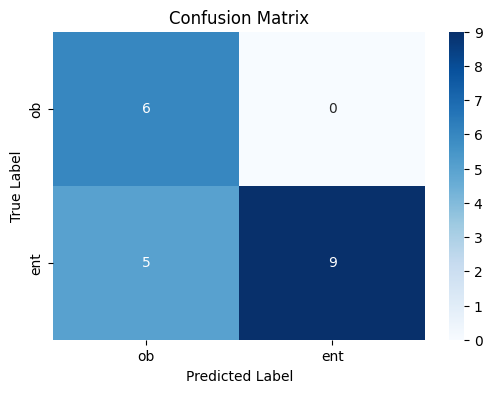

In [45]:
import pandas as pd
import numpy as np
import openai
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set your OpenAI API key
openai.api_key = "I deleted it after completing the task"

# Function to obtain an embedding vector for a given text using the new API interface
def get_embedding(text, model="text-embedding-ada-002"):
    response = openai.embeddings.create(
        input=[text],  # The input should be a list of texts
        model=model
    )
    return response.data[0].embedding

# Read data from the Excel file
df = pd.read_excel("JOM_Abstracts.xlsx")

# Map manual coding categories to numeric labels (e.g., "ob" -> 0, "ent" -> 1)
label_mapping = {"ob": 0, "ent": 1}
df["category_numeric"] = df["category"].map(label_mapping)

# Fill missing abstracts with an empty string and convert to a list
abstracts = df["Abstract"].fillna("").tolist()

# Get OpenAI embeddings for each abstract (this may take a while if there are many abstracts)
embeddings = np.array([get_embedding(text) for text in abstracts])

# Use the pre-trained OpenAI + Logistic Regression model (with C=100) to make predictions.
# Here we assume that 'log_reg_oai' is your already trained model.
predictions = log_reg_oai.predict(embeddings)

# Generate the confusion matrix and classification report
cm = confusion_matrix(df["category_numeric"], predictions)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(df["category_numeric"], predictions, target_names=["ob", "ent"]))

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ob", "ent"], yticklabels=["ob", "ent"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
